In [1]:
%run pipeline.py
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.sans-serif'] = 'Times New Roman'
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['text.usetex'] = False
plt.rcParams['mathtext.rm'] = 'Times New Roman'
plt.rcParams['mathtext.it'] = 'Times New Roman:italic'
plt.rcParams['mathtext.bf'] = 'Times New Roman:bold'
plt.rcParams['font.size'] = 14
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
#plt.rcParams['ytick.left'] = True
#plt.rcParams['ytick.right'] = True
#plt.rcParams['xtick.top'] = True
#plt.rcParams['xtick.bottom'] = True
#plt.rcParams['ytick.minor.visible'] = True

In [2]:
# Data preparation

import pandas as pd
from astropy.io import fits
import numpy as np

DLA = pd.read_csv('../../data/matched_updated_dla.csv')  # updated dla catalogue 
DR12 = fits.open('../../data/DR12Q.fits')
q_mag = []
for i in DLA['PSFMAG']:
    q_mag.append(float(i.split(',')[1]))
q_mag = np.array(q_mag)    
q = DLA[(q_mag<=22.0)&(q_mag>=5.0)
                   &(DLA['MI']<-23.78)&(DLA['MI']>-28.74)
                   &(DLA['FIRST_MATCHED']==0.)
                   &(DLA['Z_VI']<=3.4)&(DLA['Z_VI']>=2.2)
                   &(DLA['conf']>0.3)
                   &(DLA['zabs']<DLA['Z_VI'])]
q_mag = []
for i in q['PSFMAG']:
    q_mag.append(float(i.split(',')[1]))
q_mag = np.array(q_mag) 

q_dla = pd.DataFrame(np.array([q['RA_2'],q['DEC_2'],q['Z_VI'],q['zabs'],q_mag,q['MI']]).T,columns=('ra','dec','z','z_dla','MAG','MI'))
qq_dla = np.unique(np.array([q_dla['ra'],q_dla['dec'],q_dla['z']]).T,axis=0)
qq_dla = pd.DataFrame(qq_dla,columns=('ra','dec','z'))

q_dr12 = DR12[1].data[(DR12[1].data['PSFMAG'][:,1]<=22.)& (DR12[1].data['PSFMAG'][:,1]>=5.)
                            &(DR12[1].data['MI']<-23.78)&(DR12[1].data['MI']>=-28.74)
                            &(DR12[1].data['Z_VI']<=3.4)&(DR12[1].data['Z_VI']>=2.2)
                            &(DR12[1].data['FIRST_MATCHED']==0)
                            &(DR12[1].data['BOSS_TARGET1']!=0)]
q_dr12 = pd.DataFrame(np.array([q_dr12['RA'],q_dr12['DEC'],q_dr12['Z_VI'],q_dr12['PSFMAG'][:,1],q_dr12['MI']]).T,columns=('ra','dec','z','MAG','MI'))



In [3]:
'''
select different sky parts
'''

from astropy.coordinates import SkyCoord
from astropy import units as u
import healpy as hp

def sky_selection(q,l_range):
    n = SkyCoord(ra=q['ra'],dec=q['dec'],unit='deg',frame='icrs')
    ng = n.galactic
    l,b = ng.l.degree,ng.b.degree
    qq = q[(b>0)&(l>l_range[0])&(l<l_range[1])]
    
    g = SkyCoord(ra=qq['ra'],dec=qq['dec'],unit='deg',frame='icrs')
    gg = g.galactic
    l = gg.l.degree
    b = gg.b.degree
    
    # construct mask
    q_indice = hp.pixelfunc.ang2pix(32,l,b,lonlat=True)     
    q_map = np.zeros(hp.nside2npix(32), dtype=np.float)      
    for i in range(len(q_indice)):                             
        q_map[q_indice[i]] += 1

    mask = np.zeros(len(q_map))
    for i in range(len(q_map)):
        if q_map[i] == 0:       
            mask[i] = 0
        else:
            mask[i] = 1
    mask = hp.pixelfunc.ud_grade(mask,nside_out=2048)
    
    # construct map
    q_indice = hp.pixelfunc.ang2pix(2048,l,b,lonlat=True)     
    q_map = np.zeros(hp.nside2npix(2048), dtype=np.float)      
    for i in range(len(q_indice)):                             
        q_map[q_indice[i]] += 1

    # construct oversensity map
    n_tot = len(mask[mask!=0])
    q_mean = len(q_indice)/n_tot
    q_map = (q_map-q_mean)/q_mean
    
    return q_map,mask,qq

'''
Part 0. : CMB
'''
map_q,mask_q,qq = sky_selection(q_dr12,[0,100]) # select part of sky for CMB

# read CMB map    
alm = hp.fitsfunc.read_alm('../../data/Planck2018/MV/dat_klm.fits',hdu=1)
cmb_map = hp.sphtfunc.alm2map(alm,nside=2048)
mask_cmb = hp.fitsfunc.read_map('../../data/Planck2018/mask.fits') 
mask_cmb = hp.smoothing(mask_cmb,fwhm=np.deg2rad(10/60))
mask_kq = mask_cmb*mask_q         # limit CMB signals to the selected region
cmb_map *= hp.smoothing(mask_kq,fwhm=np.deg2rad(10/60))
cmb_map = hp.ma(cmb_map*mask_kq)

'''
Part 1. : QSO with DLAs
'''
map_dla,mask_dla,q_dla = sky_selection(qq_dla,[120,220])
mask_dla = hp.smoothing(mask_dla,fwhm=np.deg2rad(10/60))
map_dla = hp.ma(map_dla*mask_dla)
'''
Part 2. : QSO in DR12
'''
map_q,mask_q,q_dr12 = sky_selection(q_dr12,[120,220])
mask_q = hp.smoothing(mask_q,fwhm=np.deg2rad(10/60))
map_q = hp.ma(map_q*mask_q)


Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
NSIDE = 2048
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


/home/littlelin/anaconda3/lib/python3.7/site-packages/healpy/fitsfunc.py:352: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  "If you are not specifying the input dtype and using the default "


Sigma is 4.246609 arcmin (0.001235 rad) 
-> fwhm is 10.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 4.246609 arcmin (0.001235 rad) 
-> fwhm is 10.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 4.246609 arcmin (0.001235 rad) 
-> fwhm is 10.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 4.246609 arcmin (0.001235 rad) 
-> fwhm is 10.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


In [4]:
def bin_corr(c_kq,l_min=30,l_max=1200,band=15):   # bin the power-spectrum

    width = int((l_max-l_min)/band)                    # number of l in each bin
    bin_Cl = np.zeros((band,1))
    bin_l = np.zeros((band,1))

    for i in range(band):
        ell_min = l_min+width*i
        ell_max = l_min+(i+1)*width
        ell_seq = np.arange(ell_min,ell_max,1)
        weights = (2*ell_seq+1)/np.sum(2*ell_seq+1)
        bin_l[i] = np.sum(weights*ell_seq)
        bin_Cl[i] = np.sum(weights*c_kq[ell_min:ell_max])

    return bin_l, bin_Cl

def errorbar(q_map,cmb_map,c_kq,band=15,lmin=30,lmax=1200): # calculate errorbar for each data point

    width = int((lmax-lmin)/band)

    #f_k = len(q_map.mask[q_map.mask==True])/len(q_map.mask)  # the sky fraction of CMB map
    #f_q = len(cmb_map.mask[cmb_map.mask==True])/len(cmb_map.mask)        # the sky fraction of QSO map
  

    rec_sig2= np.zeros((band,1))


    c_qq = hp.sphtfunc.anafast(q_map.filled(),q_map.filled(),nspec=lmax) # auto correlation for QSO map
    c_kk = hp.sphtfunc.anafast(cmb_map.filled(),cmb_map.filled(),nspec=lmax) # auto correlation for CMB map

    denom_l = c_kq**2+c_kk*c_qq  # the reciprocal of var

    for a in range(len(rec_sig2)):  # calculate var for each bin
        l_max = lmin+width*(a+1)
        l_min = lmin+width*a
        rec_sig2[a] = np.sum([((2*i+1)/denom_l[i]) for i in range(l_min+1,l_max)])

    sig2 = 1/rec_sig2  

    return np.sqrt(sig2)

# Null test for QSO DR12

In [5]:
Ckq = hp.sphtfunc.anafast(map_q,cmb_map,nspec=1200)
err_dr12 = errorbar(map_q,cmb_map,Ckq,band=15)

l_dr12,cl_dr12 = bin_corr(Ckq,band=15)

%run pipeline.py
bia = bias(q_dr12['z'],2.2,3.4,0.2,[l_dr12,cl_dr12,err_dr12])

a_opt,a_std = bia.opt_curvefit()
ckl = bia.theoretical_curve(a_opt,x=bia.data_l,line=False)
bia.outlier(ckl)

a_opt,a_std = bia.opt_curvefit()

Note: redshifts have been re-sorted (earliest first)


<IPython.core.display.Math object>

<IPython.core.display.Math object>

# Null test for QSO with DLAs

In [6]:
Ckq = hp.sphtfunc.anafast(map_dla,cmb_map,nspec=1200)
err_dla = errorbar(map_q,cmb_map,Ckq,band=10)

l_dla,cl_dla = bin_corr(Ckq,band=10)

%run pipeline.py
s = np.log10(17882/17774)/0.01
bia = bias(q_dr12['z'],2.2,3.4,s,[l_dla,cl_dla,err_dla])

a_opt,a_std = bia.opt_curvefit()
ckl = bia.theoretical_curve(a_opt,x=bia.data_l,line=False)
bia.outlier(ckl)

a_opt,a_std = bia.opt_curvefit()

Note: redshifts have been re-sorted (earliest first)


<IPython.core.display.Math object>

<IPython.core.display.Math object>

/home/littlelin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Support for passing a (n, 1)-shaped error array to errorbar() is deprecated since Matplotlib 3.1 and will be removed in 3.3; pass a 1D array instead.
  """
/home/littlelin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Support for passing a (n, 1)-shaped error array to errorbar() is deprecated since Matplotlib 3.1 and will be removed in 3.3; pass a 1D array instead.
  # Remove the CWD from sys.path while we load stuff.


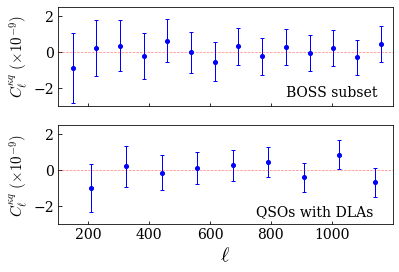

In [14]:
import matplotlib.pyplot as plt

fig,ax = plt.subplots(2,1)
plt.subplots_adjust(hspace=0.2)
ax[0].errorbar(l_dr12[1:],cl_dr12[1:]*1E9,err_dr12[1:]*1E9,fmt='o',c='b',elinewidth=1,capsize=2,ms=4,label='BOSS subset')
ax[0].axhline(y=0,alpha=0.5,ls='--',c='red',lw=0.7)
ax[0].text(s='BOSS subset',x=850,y=-2.5,fontsize=14)
ax[0].tick_params(labelbottom=False)
ax[0].set_ylabel(r'$C_{\ell}^{\kappa q}~(\times 10^{-9})$',fontsize=15)
ax[1].errorbar(l_dla[1:],cl_dla[1:]*1E9,err_dla[1:]*1E9,fmt='o',elinewidth=1,c='b',capsize=2,ms=4,label='QSOs with DLAs')
ax[1].axhline(y=0,alpha=0.5,ls='--',c='red',lw=0.7)
ax[1].set_ylabel(r'$C_{\ell}^{\kappa q}~(\times 10^{-9})$',fontsize=15)
ax[1].text(s='QSOs with DLAs',x=750,y=-2.5,fontsize=14)
ax[1].set_xlabel(r'$\ell$',fontsize=20)

ax[0].set_xlim(100,1200)
ax[0].set_ylim(-3.,2.5)
ax[0].set_xticks([200,400,600,800,1000])
ax[1].set_xlim(100,1200)
ax[1].set_xticks([200,400,600,800,1000])
ax[1].set_ylim(-3.,2.5)
plt.savefig('null_test.pdf',bbox_inches='tight',pad_inches=0)
plt.show()